In [66]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Read in data, check formatting compatibility
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

labels = pd.read_pickle(pickle_path / "labels.pkl")
X = pd.read_pickle(pickle_path / "X_all.pkl")
y = pd.read_pickle(pickle_path / "y_all.pkl")

if X.shape[0] != y.shape[0]: 
    # TODO: Raise Error
    print("ERROR. Dataframe shapes don't match.\n"
          "X Rows: {}"
          "y Rows: {}".format(X.shape, y.shape))

In [19]:
# Remove houses without EVs
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")
print("{} Houses without EVs".format(len(houses_woEV)))

y = y.drop(houses_woEV, errors='ignore')
X = X.drop(houses_woEV, errors='ignore')

print("Features:")
for feature in X.columns.tolist(): 
    print("  " + feature)

1105 Houses without EVs
Features:
	value
	diff
	h8_avg
	h24_avg
	h24_min
	h24_max
	h72_avg
	diff_2
	diff_3
	diff_5


In [73]:
# Scale and Split Training Data
X_train, X_test, y_train, y_test = utils.scale_split_data(X,y)

# Train logistic regression model
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Train Score: {:.4f}".format(logreg.score(X_train, y_train)))
print("Test Score: {:.4f}".format(logreg.score(X_test, y_test)))

utils.make_pickle(logreg, pickle_path / 'b_logreg.pkl')

Train Score: 0.9458
Test Score: 0.9455


### Intercept and Coefficient Evaluation

INTERCEPT
2.2% probability of house having an EV


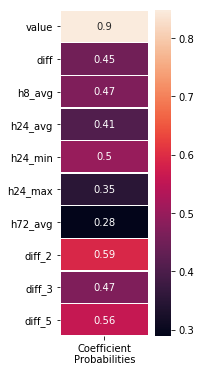

In [67]:
utils.logreg_evaluation(logreg, X_train, 'b_lr', fig_path)

### ROC and PR

ROC AUC Score: 0.925
Average Precision Score: 0.624
Balanced Accuracy Score: 0.713


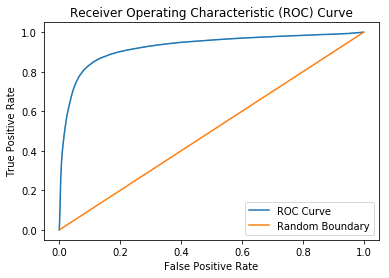

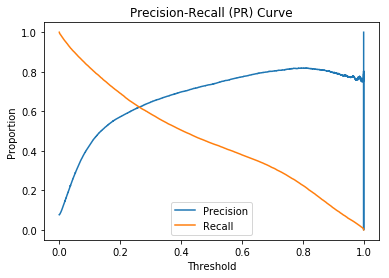

Training Score, 0.946
Testing Score, 0.946
ROC AUC, 0.925
Average Precision Score, 0.624
Balanced Accuracy Score, 0.713


In [69]:
utils.model_evaluation(logreg, X_train, y_train, X_test, y_test, 'b_lr', fig_path)